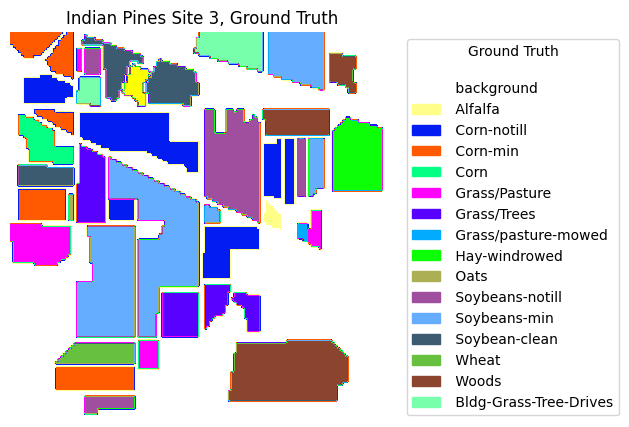

In [2]:
import numpy as np
import pandas as pd
from osgeo import gdal
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction import image


class IndianPines():

    site3_filename = '19920612_AVIRIS_IndianPine_Site3.tif'
    site3_gr_filename = '19920612_AVIRIS_IndianPine_Site3_gr.tif'
    site3_gr_classes_filename = 'AVIRIS_IndianPine_Site3_classes.csv'
    def __init__(self):

        self.raster_data = gdal.Open(IndianPines.site3_filename)
        self.ground_truth = gdal.Open(IndianPines.site3_gr_filename)
        self.class_df = pd.read_csv(IndianPines.site3_gr_classes_filename)


    def scale(self):

        scaler = MinMaxScaler()
        raster_array = self.raster_data.ReadAsArray()
        b, h, w = raster_array.shape
        raster_array = scaler.fit_transform(raster_array.reshape((b, h * w)).T)
        return raster_array.reshape(h, w, b)

    def get_cmap(self):
        colors = [tuple(c) for c in (self.class_df[['R', 'G', 'B']] / 255).values]
        cm = ListedColormap(colors)
        return cm

    def show(self, patch=None, bands=[29, 19, 9], ax=None):
        ax = ax or plt.gca()
        if patch:
            img = self.get_patch(*patch, 5)[:, :, bands]
            title = 'Indian Pines Site 3 False Color\nPatch ({}, {})'.format(*patch)
        else:
            img = self.scale()[:, :, bands]
            title = 'Indian Pines Site 3\n False Color'

        ax.imshow(img)
        ax.set_axis_off()
        ax.set_title(title + '\nBands {}, {}, {}'.format(*bands))
    
    def get_patch(self, i, j, p=5):
        scaled_data = self.scale()
        padded_data = np.pad(scaled_data, ((p // 2, p // 2), (p // 2, p // 2), (0, 0)), mode='constant')
        return padded_data[i:i + p,j:j + p, :]
    
    def get_patches(self, p=5):
        scaled_data = self.scale()
        padded_data = np.pad(scaled_data, ((p // 2, p // 2), (p // 2, p // 2), (0, 0)), mode='constant')
        patches = image.extract_patches_2d(padded_data, (p, p))
        return patches          
        
    
    def show_gt(self, ax=None):
        ax = ax or plt.gca()
        gt_data = self.ground_truth.ReadAsArray()
        
        cm = self.get_cmap()
        ax.imshow(gt_data, cmap=cm)
        ax.set_axis_off()
        bound = list(range(0, 17))

        fig = ax.get_figure()
        fig.set_figwidth(7)
        fig.set_figheight(5)
        plt.legend([mpatches.Patch(color=cm(b)) for b in bound[:-1]],
                    [name for name in list(self.class_df['class_name'])[:-1]], 
                    bbox_to_anchor=(1.6, 1),
                    title='Ground Truth\n')
        ax.set_title('Indian Pines Site 3, Ground Truth')
        
        ax.set_axis_off()
        plt.show()
        
    def show_pred(self, y_pred, ax=None):
        ax = ax or plt.gca()
        
        cm = self.get_cmap()
        ax.imshow(y_pred.reshape(145, 145), cmap=cm)
        ax.set_axis_off()
        bound = list(range(0, 17))

        fig = ax.get_figure()
        fig.set_figwidth(7)
        fig.set_figheight(5)
        plt.legend([mpatches.Patch(color=cm(b)) for b in bound[:-1]],
                    [name for name in list(self.class_df['class_name'])[:-1]], 
                    bbox_to_anchor=(1.6, 1),
                    title='Ground Truth\n')
        ax.set_title('Indian Pines Site 3, Ground Truth Prediction')
        
        ax.set_axis_off()
        plt.show()
        
    def get_gt(self, pixel=None):
        gt_data = self.ground_truth.ReadAsArray()
        if pixel:
            return gt_data[pixel[0], pixel[1]]
        else:
            return gt_data.reshape(gt_data.shape[0] * gt_data.shape[1], 1)
    
    def get_dataset(self, n=None):
        if n:
            return self.get_patches()[:n], self.get_gt()[:n]
        else:
            return self.get_patches(), self.get_gt()

if __name__ == '__main__':

    indian_pines = IndianPines()
    indian_pines.show(bands=[29, 19, 9], patch=(0, 0))
    indian_pines.show_gt()
    